### Salary Classification Model

The aim of this project is to predict the salary range of the data scientists based on the important features selected from the survey response.

For this we follow below steps
1. Import required libraries and create a dataframe of the CSV file
2. Identify feature and target variables, perform data cleaning by removing information that is not relavent to our study
3. Perform analysis on the cleaned data to identify the correlation, trends, statistical mean, diviations and so on
4. Perform feature selection using any tool like Lasso, random forest classifier and select important features
5. Further dimension reduction to by done by PCA and build a model with K fold cross validation
6. Once the model is done, we check for accuracy and perform parameter tuning to improve the accuray
7. Now that the improved accuracy is achieved, we proceed to apply model on unseen data and recheck the accuracy 

## 1. Importing required libraries and Creating DataSet

In [162]:
#Importing all the libraries that may be required
import numpy as np
import pandas as pd
import random
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss

# The following line is needed to show plots inline in notebooks
%matplotlib inline 

Salaries = pd.read_csv("multipleChoiceResponses.csv", low_memory = False)

# 2. Data cleaning

Drop rows that are irralavant to our study, rows with missing target values. Data cleaning is the necessary part of the analysis as the data from public source or surveys conducted will have lot of unwanted information, fake responses and that are not relaiable. Proper cleaning will reduce over fitting, reduce computational time. Also, it eases the ML model to predict the output in a better way

In [163]:
Salaries['Q9'].isna().sum()

3674

In [164]:
Salaries.dropna(subset=['Q9'],inplace=True) 

In [165]:
Salaries.Q9.unique() 

array(['What is your current yearly compensation (approximate $USD)?',
       '10-20,000', '0-10,000',
       'I do not wish to disclose my approximate yearly compensation',
       '20-30,000', '125-150,000', '30-40,000', '50-60,000',
       '100-125,000', '90-100,000', '70-80,000', '80-90,000', '60-70,000',
       '400-500,000', '40-50,000', '150-200,000', '500,000+',
       '300-400,000', '200-250,000', '250-300,000'], dtype=object)

 Dropping the rows with target value not declared

In [166]:
Salaries = Salaries[Salaries['Q9']!= "I do not wish to disclose my approximate yearly compensation"]
Salaries=Salaries.reset_index()

In [167]:
Salaries=Salaries.drop(['index'],axis=1)

Respondents with age less than number of years of experience and to be ambiguous. Also, respondents with 80+ age mostly selected 'none' and prefer not to say options but disclosed salary as 500,000+ seems not genuine. So we drop those rows

In [168]:
Salaries=Salaries[Salaries['Q2']!='80+']
Salaries=Salaries.drop([0],axis=0)

In [169]:
Salaries[Salaries['Q8']=='30 +'].head()

,Time from Start to Finish (seconds),Q1,Q1_OTHER_TEXT,Q2,Q3,Q4,Q5,Q6,Q6_OTHER_TEXT,Q7,...,Q49_OTHER_TEXT,Q50_Part_1,Q50_Part_2,Q50_Part_3,Q50_Part_4,Q50_Part_5,Q50_Part_6,Q50_Part_7,Q50_Part_8,Q50_OTHER_TEXT
392,15717,Male,-1,25-29,China,Professional degree,"Computer science (software engineering, etc.)",Software Engineer,-1,Computers/Technology,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
1049,954,Male,-1,60-69,Brazil,Doctoral degree,Engineering (non-computer focused),Research Scientist,-1,Government/Public Service,...,-1,NaN,Too time-consuming,NaN,NaN,Not enough incentives to share my work,NaN,NaN,NaN,-1
1201,5871,Prefer to self-describe,6,55-59,Italy,Master’s degree,"Medical or life sciences (biology, chemistry, ...",Consultant,-1,Computers/Technology,...,-1,Too expensive,Too time-consuming,Requires too much technical knowledge,Afraid that others will use my work without gi...,NaN,NaN,NaN,NaN,-1
1259,1389,Male,-1,40-44,Sweden,Some college/university study without earning ...,Physics or astronomy,Software Engineer,-1,Online Service/Internet-based Services,...,-1,NaN,NaN,NaN,NaN,NaN,NaN,None of these reasons apply to me,NaN,-1
1321,914,Male,-1,70-79,Brazil,Doctoral degree,"Humanities (history, literature, philosophy, e...",Data Scientist,-1,Academics/Education,...,-1,Too expensive,Too time-consuming,NaN,NaN,NaN,NaN,NaN,NaN,-1


In [170]:
ambiguous_rows=Salaries[(Salaries['Q8']=='30 +') & (pd.to_numeric(Salaries['Q2'].str.split('-').str[0])<=35)]
ambiguous_rows=ambiguous_rows.append(Salaries[(Salaries['Q8']=='25-30') & (pd.to_numeric(Salaries['Q2'].str.split('-').str[0])==30)])
ambiguous_rows=ambiguous_rows.append(Salaries[(Salaries['Q8']=='20-25') & (pd.to_numeric(Salaries['Q2'].str.split('-').str[0])==18)])
Salaries=Salaries.drop(ambiguous_rows.index,axis=0)

In [171]:
Salaries=Salaries.reset_index()
Salaries=Salaries.drop(['index'],axis=1)

In [172]:
Salaries.loc[0:,'index'] = Salaries.index

Dropping the columns with Values that are encoded and cannot be used for our study unless we know the coded information. 

In [173]:
#Droping the columns with "_OTHER_TEXT"

Salaries.drop(Salaries[[col for col in Salaries.columns if '_TEXT' in col]],axis=1,inplace=True)
Salaries.columns[10]

Index(['Time from Start to Finish (seconds)', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5',
       'Q6', 'Q7', 'Q8', 'Q9',
       ...
       'Q49_Part_12', 'Q50_Part_1', 'Q50_Part_2', 'Q50_Part_3', 'Q50_Part_4',
       'Q50_Part_5', 'Q50_Part_6', 'Q50_Part_7', 'Q50_Part_8', 'index'],
      dtype='object', length=362)

Values in columns which are just an opinion of the respondent and which are specific to a person are removed. 

In [174]:
#Dropping the columns that are irrelavant to the study (which are a meare opinions of the respondents)
irrelavant_col=[col for col in Salaries.columns if (col.startswith('Time')) or(col.startswith('Q50')) or (col.startswith('Q49')) or (col.startswith('Q48')) or (col.startswith('Q47')) or (col.startswith('Q45')) or (col.startswith('Q44')) or (col.startswith('Q42')) or (col.startswith('Q41')) or (col.startswith('Q40')) or (col.startswith('Q39')) or (col.startswith('Q37'))or (col.startswith('Q35'))or (col.startswith('Q34'))or (col.startswith('Q26'))or (col.startswith('Q32_OTHER')) or (col.startswith('Q18'))]

In [175]:
Salaries.drop(irrelavant_col,axis=1,inplace=True)

In [176]:
Salaries.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q38_Part_16,Q38_Part_17,Q38_Part_18,Q38_Part_19,Q38_Part_20,Q38_Part_21,Q38_Part_22,Q43,Q46,index
0,Male,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,Manufacturing/Fabrication,5-10,"10-20,000",No (we do not use ML methods),...,NaN,NaN,NaN,NaN,NaN,None/I do not know,NaN,NaN,NaN,0
1,Female,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,I am a student,0-1,"0-10,000",I do not know,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-10,10-20,1
2,Male,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,I am a student,0-1,"0-10,000",I do not know,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20-30,20-30,2
3,Male,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,Academics/Education,10-15,"10-20,000",No (we do not use ML methods),...,NaN,NaN,NaN,NaN,NaN,None/I do not know,NaN,0-10,0,3
4,Male,18-21,India,Master’s degree,"Information technology, networking, or system ...",Other,Other,0-1,"0-10,000","We recently started using ML methods (i.e., mo...",...,NaN,NaN,Medium Blog Posts,NaN,NaN,NaN,NaN,0,10-20,4


### Imputing missing values and Encoding the columns

After removing the unnecessary information. The next step is dealing with missing values. 
We observe that the responses are of two categories, such as multiple ans questions and single answer questions. 
Splitting the columns that are single choice from that are multiple choice (drop down and tick box type)

Once the splitting is done. The missing values are identified, analysed with respect to target data and other features and fill them using some methods like label encoding, mapping, filling.

In [177]:
single_ans=Salaries[[col for col in Salaries.columns if '_Part' not in col]]
multi_ans=Salaries[[col for col in Salaries.columns if '_Part' in col]]
multi_ans.head()

,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,Q11_Part_6,Q11_Part_7,Q13_Part_1,Q13_Part_2,Q13_Part_3,...,Q38_Part_13,Q38_Part_14,Q38_Part_15,Q38_Part_16,Q38_Part_17,Q38_Part_18,Q38_Part_19,Q38_Part_20,Q38_Part_21,Q38_Part_22
0,NaN,NaN,NaN,NaN,NaN,None of these activities are an important part...,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None/I do not know,NaN
1,Analyze and understand data to influence produ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,Other,NaN,RStudio,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,None of these activities are an important part...,NaN,NaN,RStudio,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None/I do not know,NaN
4,NaN,Build and/or run a machine learning service th...,NaN,NaN,NaN,NaN,NaN,Jupyter/IPython,NaN,PyCharm,...,NaN,NaN,NaN,NaN,NaN,Medium Blog Posts,NaN,NaN,NaN,NaN


In [178]:
single_ans.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q17,Q20,Q22,Q23,Q24,Q25,Q32,Q43,Q46,index
0,Male,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,Manufacturing/Fabrication,5-10,"10-20,000",No (we do not use ML methods),...,NaN,NaN,NaN,1% to 25% of my time,I have never written code but I want to learn,I have never studied machine learning but plan...,NaN,NaN,NaN,0
1,Female,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,I am a student,0-1,"0-10,000",I do not know,...,Java,NaN,ggplot2,75% to 99% of my time,5-10 years,< 1 year,Time Series Data,0-10,10-20,1
2,Male,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,I am a student,0-1,"0-10,000",I do not know,...,SQL,NaN,NaN,75% to 99% of my time,5-10 years,2-3 years,NaN,20-30,20-30,2
3,Male,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,Academics/Education,10-15,"10-20,000",No (we do not use ML methods),...,NaN,NaN,NaN,25% to 49% of my time,< 1 year,< 1 year,Numerical Data,0-10,0,3
4,Male,18-21,India,Master’s degree,"Information technology, networking, or system ...",Other,Other,0-1,"0-10,000","We recently started using ML methods (i.e., mo...",...,NaN,Keras,Matplotlib,75% to 99% of my time,< 1 year,< 1 year,Image Data,0,10-20,4


First we deal with multiple answer set as the set is alreay available in long form where the nan and 1 value are existing in a coloumn. Upon checking the unique values in each column, we replace NaN values by '0' and the other value by '1'

In [179]:
for i in multi_ans.columns:
    print(i,multi_ans[i].unique())

Q11_Part_1 [nan
 'Analyze and understand data to influence product or business decisions']
Q11_Part_2 [nan
 'Build and/or run a machine learning service that operationally improves my product or workflows']
Q11_Part_3 [nan
 'Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data']
Q11_Part_4 [nan 'Build prototypes to explore applying machine learning to new areas']
Q11_Part_5 [nan 'Do research that advances the state of the art of machine learning']
Q11_Part_6 ['None of these activities are an important part of my role at work' nan]
Q11_Part_7 [nan 'Other']
Q13_Part_1 [nan 'Jupyter/IPython']
Q13_Part_2 [nan 'RStudio']
Q13_Part_3 [nan 'PyCharm']
Q13_Part_4 [nan 'Visual Studio Code']
Q13_Part_5 [nan 'nteract']
Q13_Part_6 [nan 'Atom']
Q13_Part_7 [nan 'MATLAB']
Q13_Part_8 [nan 'Visual Studio']
Q13_Part_9 [nan 'Notepad++']
Q13_Part_10 [nan 'Sublime Text']
Q13_Part_11 [nan 'Vim']
Q13_Part_12 [nan 'IntelliJ']
Q13_Part_13 [nan 'Spyder']

In [180]:
import warnings
#warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")
for col in multi_ans.columns:
    multi_ans[col]=multi_ans[col].apply(lambda x: 0 if pd.isnull(x) else 1 )
    

Checking the encoded multiple answer set and verify if any nan values still exist 

In [181]:
multi_ans.head()

,Q11_Part_1,Q11_Part_2,Q11_Part_3,Q11_Part_4,Q11_Part_5,Q11_Part_6,Q11_Part_7,Q13_Part_1,Q13_Part_2,Q13_Part_3,...,Q38_Part_13,Q38_Part_14,Q38_Part_15,Q38_Part_16,Q38_Part_17,Q38_Part_18,Q38_Part_19,Q38_Part_20,Q38_Part_21,Q38_Part_22
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0


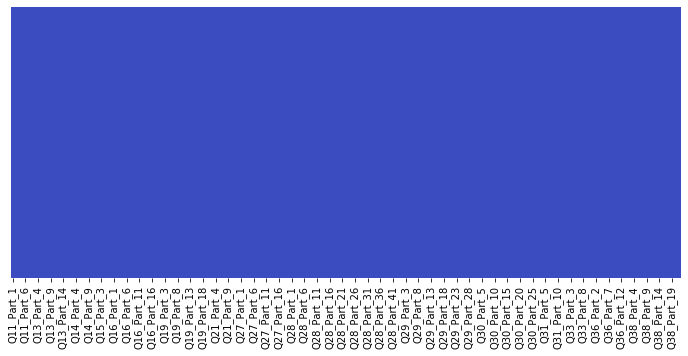

In [182]:
fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(multi_ans.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)

#### Now, we check the null values in single answer set and impute the missing values

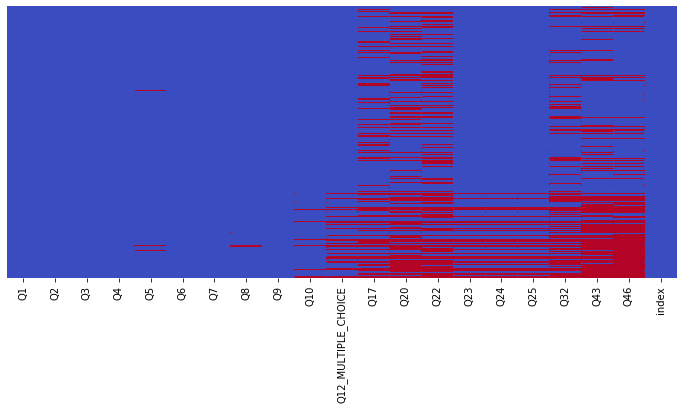

In [183]:
fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(single_ans.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)

From heat map, it is observed that Q5, Q8, Q10, Q23, Q24, Q25 has less missing values (<15%) hence we impute them seperately. Nan of Q5 by 'none since they have no education, Q8 by '0-1' years since they are students. Rest my 'mode' of the coloumn

In [184]:
for col in ['Q10','Q12_MULTIPLE_CHOICE','Q23','Q24','Q25']:
    print("% of missing values in "+col+" is {:.2f}".format(single_ans[col].isna().sum()/len(single_ans[col])*100))

% of missing values in Q10 is 1.89
% of missing values in Q12_MULTIPLE_CHOICE is 10.17
% of missing values in Q23 is 12.71
% of missing values in Q24 is 12.84
% of missing values in Q25 is 13.00


In [185]:
warnings.filterwarnings("ignore")
for col in ['Q10','Q12_MULTIPLE_CHOICE','Q23','Q24','Q25']:
    single_ans[col]=single_ans[col].fillna(single_ans[col].mode()[0])

In [186]:
single_ans[single_ans['Q5'].isna()]['Q4']

174      No formal education past high school
533      No formal education past high school
657      No formal education past high school
959      No formal education past high school
1054     No formal education past high school
                         ...                 
15102    No formal education past high school
15108    No formal education past high school
15131    No formal education past high school
15172    No formal education past high school
15256    No formal education past high school
Name: Q4, Length: 129, dtype: object

In [187]:
single_ans['Q5'].fillna('None',inplace=True)
warnings.filterwarnings("ignore")

In [188]:
single_ans[single_ans['Q8'].isnull()]['Q6'].value_counts()

Student               64
Business Analyst       4
Data Analyst           3
Data Scientist         1
Consultant             1
Software Engineer      1
Research Scientist     1
Other                  1
Name: Q6, dtype: int64

In [189]:
single_ans['Q8'].fillna('0-1',inplace=True)

Imputing the missing values of columns (with higher % of missing values) by considering a random variable from respective column as if the replacement is done by 'mode' or 'most-frequent' it will be over loading the same value. Also, random function will maintain the distribution

In [190]:
def imputing(col):
    rand=single_ans[col].dropna().sample(single_ans[col].isnull().sum(), random_state=0)
    rand.index=single_ans[single_ans[col].isnull()].index
    single_ans.loc[single_ans[col].isnull(),col]=rand
    

In [191]:
for col in ['Q17','Q20','Q22','Q32','Q43','Q46']:
    imputing(col)
    
warnings.filterwarnings("ignore")    

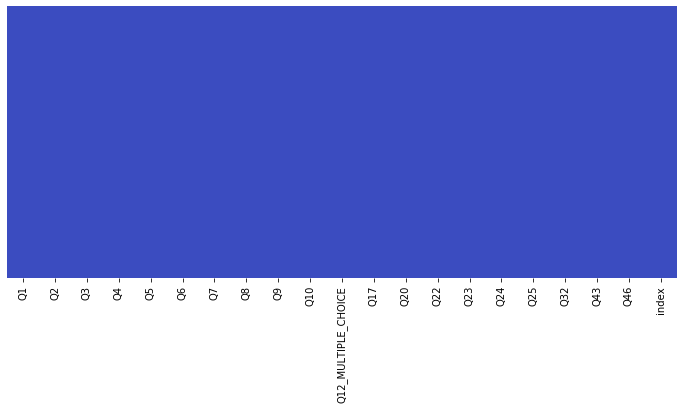

In [192]:
fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(single_ans.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)

#### Now that our data is free from missing values, we proceed for 1 hot encoding and split the single ans set as multiple ans set
Taken from the tutorials of logitic regression and the presentations by other team.
Categorical variables needs to be converted into numerical values since scikit-learn only takes numerical values as input in a numpy array.

We could represent categorical values using numbers, but this encoding implies an ordered relationship between the values in the category. To avoid this, we can encode categorical values using dummy variables. We can convert these via onehotencoding where each category for each feature becomes a new column. A category's column will get a value of 1 if the original feature belonged to that category. Only one of the categorical feature columns can have of 1.

In [193]:
single_ans_encoded=pd.get_dummies(single_ans.drop(['index','Q9'],axis=1))

In [194]:
single_ans_encoded.head()

,Q1_Female,Q1_Male,Q1_Prefer not to say,Q1_Prefer to self-describe,Q2_18-21,Q2_22-24,Q2_25-29,Q2_30-34,Q2_35-39,Q2_40-44,...,Q46_0-10,Q46_10-20,Q46_20-30,Q46_30-40,Q46_40-50,Q46_50-60,Q46_60-70,Q46_70-80,Q46_80-90,Q46_90-100
0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


#### Merging the multiple set with encoded single answer set

In [195]:
feature_data=pd.concat([multi_ans,single_ans_encoded], axis=1)
feature_data.columns

Index(['Q11_Part_1', 'Q11_Part_2', 'Q11_Part_3', 'Q11_Part_4', 'Q11_Part_5',
       'Q11_Part_6', 'Q11_Part_7', 'Q13_Part_1', 'Q13_Part_2', 'Q13_Part_3',
       ...
       'Q46_0-10', 'Q46_10-20', 'Q46_20-30', 'Q46_30-40', 'Q46_40-50',
       'Q46_50-60', 'Q46_60-70', 'Q46_70-80', 'Q46_80-90', 'Q46_90-100'],
      dtype='object', length=527)

#### Converting target variable from bins to numeric for data analysis

In [196]:
target_data=single_ans['Q9']
target_data=target_data.str.split('-').str[1]
target_data.fillna('500,001',inplace=True)

In [197]:
target_data=target_data.astype(str)

In [198]:
target_data

0         20,000
1         10,000
2         10,000
3         20,000
4         10,000
          ...   
15397    100,000
15398     10,000
15399     20,000
15400    300,000
15401     20,000
Name: Q9, Length: 15402, dtype: object

In [199]:
for i in range(len(target_data)):
    target_data[i]=''.join(e for e in target_data[i] if e.isdigit())
target_data=target_data.astype(int)    

# 3.Exploratory Data Analysis

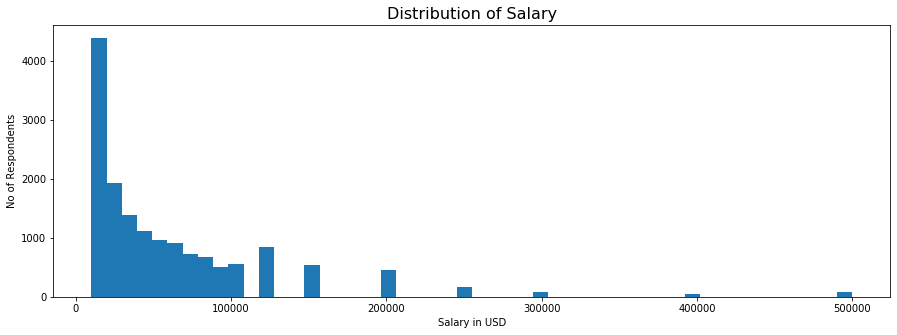

In [200]:
plt.figure(figsize=(15,5))
plt.hist(target_data,bins=50, label=str)
plt.xlabel('Salary in USD')
plt.ylabel('No of Respondents')
plt.title('Distribution of Salary',size=16)
plt.show()

It is observed from the above distribution that most of the respondents salary falls in the range of 0-30,000 USD. Now we check the distribution patterns with respect to some important features like age, country and experience.

In [201]:
Salaries_an=pd.concat([single_ans.drop(['Q9'],axis=1),multi_ans,target_data],axis=1)
Salaries_an.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q10,Q12_MULTIPLE_CHOICE,...,Q38_Part_14,Q38_Part_15,Q38_Part_16,Q38_Part_17,Q38_Part_18,Q38_Part_19,Q38_Part_20,Q38_Part_21,Q38_Part_22,Q9
0,Male,30-34,Indonesia,Bachelor’s degree,Engineering (non-computer focused),Other,Manufacturing/Fabrication,5-10,No (we do not use ML methods),"Basic statistical software (Microsoft Excel, G...",...,0,0,0,0,0,0,0,1,0,20000
1,Female,30-34,United States of America,Master’s degree,"Computer science (software engineering, etc.)",Data Scientist,I am a student,0-1,I do not know,Local or hosted development environments (RStu...,...,0,0,0,0,0,0,0,0,0,10000
2,Male,22-24,India,Master’s degree,Mathematics or statistics,Data Analyst,I am a student,0-1,I do not know,"Advanced statistical software (SPSS, SAS, etc.)",...,0,0,0,0,0,0,0,0,0,10000
3,Male,35-39,Chile,Doctoral degree,"Information technology, networking, or system ...",Other,Academics/Education,10-15,No (we do not use ML methods),"Basic statistical software (Microsoft Excel, G...",...,0,0,0,0,0,0,0,1,0,20000
4,Male,18-21,India,Master’s degree,"Information technology, networking, or system ...",Other,Other,0-1,"We recently started using ML methods (i.e., mo...",Local or hosted development environments (RStu...,...,0,0,0,0,1,0,0,0,0,10000


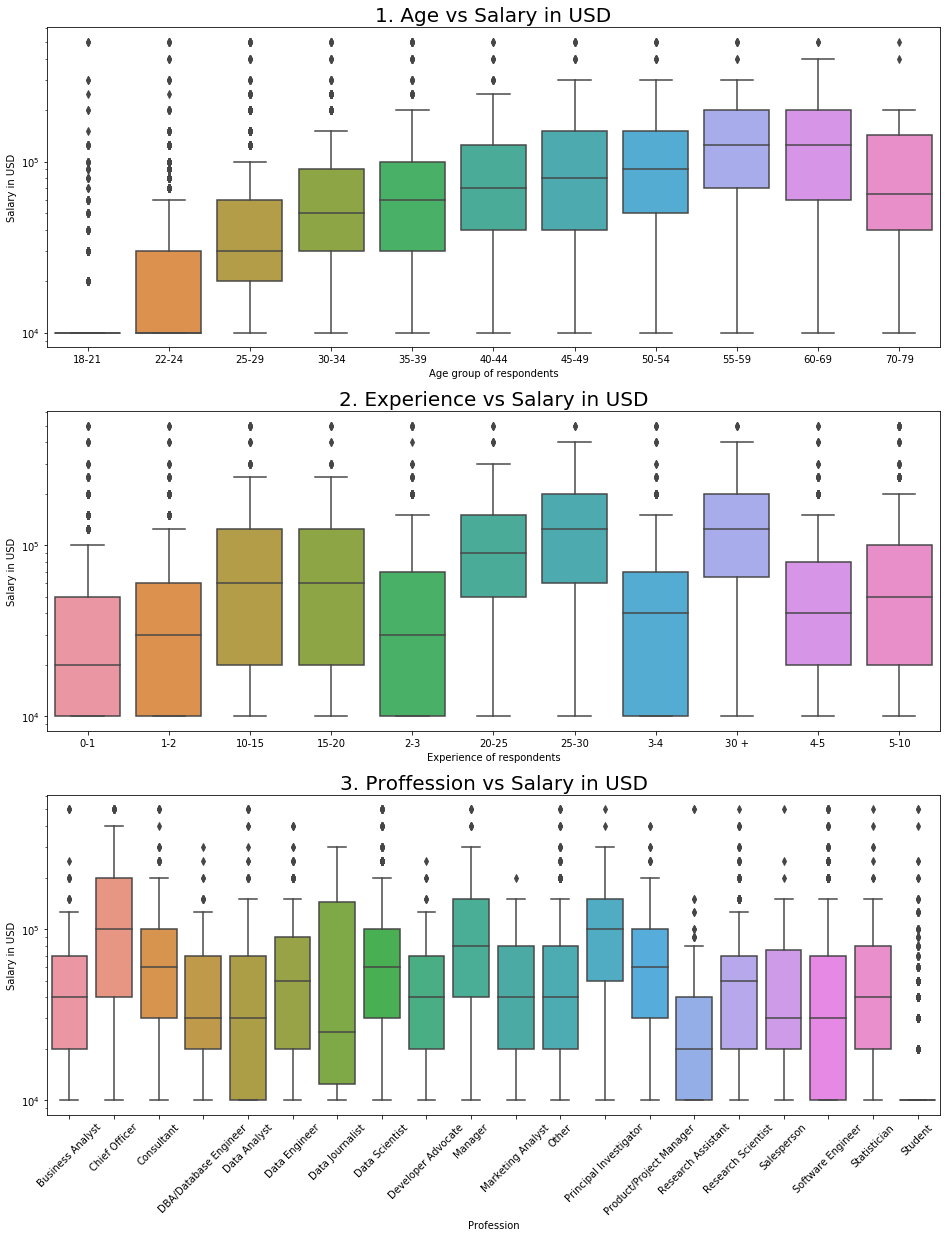

In [202]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(16,20))
age_sal=sns.boxplot(x='Q2',y='Q9', data=Salaries_an.sort_values(['Q2']), ax=ax1)
age_sal.set(xlabel='Age group of respondents',ylabel='Salary in USD')
age_sal.set(yscale="log")
age_sal.axes.set_title('1. Age vs Salary in USD', fontsize=20)
# age_sal.set(ylim=(10000, 500000))

exp_sal=sns.boxplot(x='Q8',y='Q9', data=Salaries_an.sort_values(['Q8']), ax=ax2)
exp_sal.set(xlabel='Experience of respondents',ylabel='Salary in USD')
exp_sal.set(yscale="log")
exp_sal.axes.set_title('2. Experience vs Salary in USD', fontsize=20)

prof_sal=sns.boxplot(x='Q6',y='Q9', data=Salaries_an.sort_values(['Q6']), ax=ax3)
prof_sal.set(xlabel='Profession',ylabel='Salary in USD')
prof_sal.set(yscale="log")
prof_sal.axes.set_title('3. Profession vs Salary in USD', fontsize=20)
prof_sal.set_xticklabels(prof_sal.get_xticklabels(),rotation=45)

plt.show()


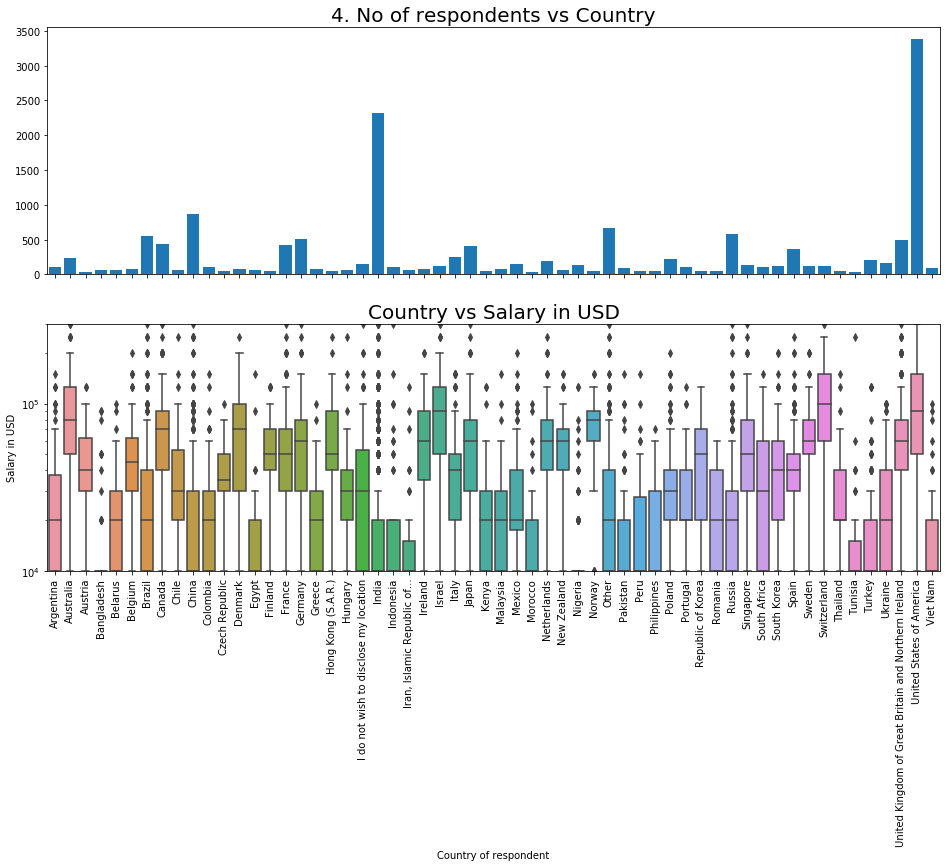

In [203]:
fig, (a1, a2) = plt.subplots(2,1, figsize=(16,10), sharex='all')

con_count=pd.DataFrame(Salaries_an.Q3.value_counts())
con_count=con_count.reset_index()
con_count=con_count.sort_values(['index'])
a1.bar(x='index',height='Q3',data=con_count)
a1.set_xticklabels(a1.get_xticklabels(),rotation=50)
a1.set(ylabel='Count of respondents')
a1.axes.set_title('4. No of respondents vs Country', fontsize=20)

Salaries_an=Salaries_an.sort_values(['Q3'])
a2=sns.boxplot(x='Q3',y='Q9', data=Salaries_an)
a2.set(xlabel='Country of respondent',ylabel='Salary in USD')
a2.set(yscale="log")
a2.set_xticklabels(a2.get_xticklabels(),rotation=90)
a2.axes.set_title('Country vs Salary in USD', fontsize=20)
a2.set(ylim=(10000, 300000))
plt.show()

It is evident that age is a very good indicator to predict the salary as the mean salary of different age group is varying. Also in countries like USA, Austrilia, Israil and switzerland the salaries of a data analyst are high comparably. 
Another noticeable aspect in the graph above is that there are several outliers in each group of observation, and these could hardly affect the accuracy of the prediction.

# 4.Feature selection

Instead of deducing the relationship between features and target data graphically, we can also check the correlation by corelation matrix. For that, we need to encode the data again using label encoding. But due to weigh factor it is unlikely that the model can give good results by the features selected using the covarience matirix. 
Albiet we can get a basic idea regarding the direction of the correlation. 

In [204]:
# Import label encoder 
from sklearn import preprocessing 
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 

single_ans_le=pd.concat([single_ans.drop(['Q9','index'],axis=1),target_data],axis=1)
  
# Encode labels in column 'species'. 
No=['Q2','Q4','Q8','Q9','Q43','Q46'] #columns where the order is to be intact (numericals)
single_ans_le=[label_encoder.fit_transform(single_ans_le[col]) for col in single_ans_le.columns if col not in No]

In [205]:
col_names=pd.concat([single_ans.drop(['Q9','index','Q2','Q4','Q8','Q9','Q43','Q46'],axis=1)],axis=1).columns
single_ans_le=pd.DataFrame(single_ans_le)
single_ans_le=single_ans_le.transpose()
single_ans_le.columns=col_names

Now we encode the columns where order plays significant role. For instance, considering Q2 column where age bucket is the response recorded. If we use label encoding on this column, the first unique value is coded as 0 and the next 1 and so on. If the age of respondent in first row is 40-50, it is coded as 0 and if second is 10-20 it is coded as 1 where as as per order 10-20 must be given better rank than 40-50. 

Hence we manually code such columns using map function

In [206]:
#Encoding columns with numericals where order is to be considered
single_ans_le['Q2']=single_ans['Q2'].map({'18-21': 0, '22-24': 1, '25-29':2, '30-34':3, '35-39':4, '40-44':5, '45-49':6, '50-54':7, '55-59':8, '60-69':9, '70-79':10}).astype(int)
single_ans_le['Q4']=single_ans['Q4'].map({'Bachelor’s degree': 0, 'Master’s degree': 1, 'Doctoral degree':2, 'Professional degree':3, 'Some college/university study without earning a bachelor’s degree':4, 'I prefer not to answer':5, 'No formal education past high school':6}).astype(int)
single_ans_le['Q8']=single_ans['Q8'].map({'0-1':0, '1-2':1, '2-3':2, '3-4':3, '4-5':4, '5-10':5, '10-15':6, '15-20':7, '20-25':8, '25-30':9, '30 +':10}).astype(int)
single_ans_le['Q43']=single_ans['Q43'].map({'0':0, '0-10':1, '10-20':2, '20-30':3, '30-40':4, '40-50':5, '50-60':6, '60-70':7, '70-80':8, '80-90':9, '90-100':10}).astype(int)
single_ans_le['Q46']=single_ans['Q46'].map({'0':0, '0-10':1, '10-20':2, '20-30':3, '30-40':4, '40-50':5, '50-60':6, '60-70':7, '70-80':8, '80-90':9, '90-100':10}).astype(int)
single_ans_le['Q9']=target_data
single_ans_le.head()

,Q1,Q3,Q5,Q6,Q7,Q10,Q12_MULTIPLE_CHOICE,Q17,Q20,Q22,Q23,Q24,Q25,Q32,Q2,Q4,Q8,Q43,Q46,Q9
0,1,22,2,11,9,1,1,9,10,2,1,9,9,1,3,0,5,1,8,20000
1,0,56,1,7,7,0,4,4,10,11,5,6,7,10,3,1,0,1,2,10000
2,1,21,8,4,7,0,0,14,12,11,5,6,2,5,1,1,0,3,3,10000
3,1,8,7,11,0,1,1,5,10,6,3,7,7,5,4,2,6,1,0,20000
4,1,21,7,11,16,4,4,10,5,6,5,7,7,4,0,1,0,0,2,10000


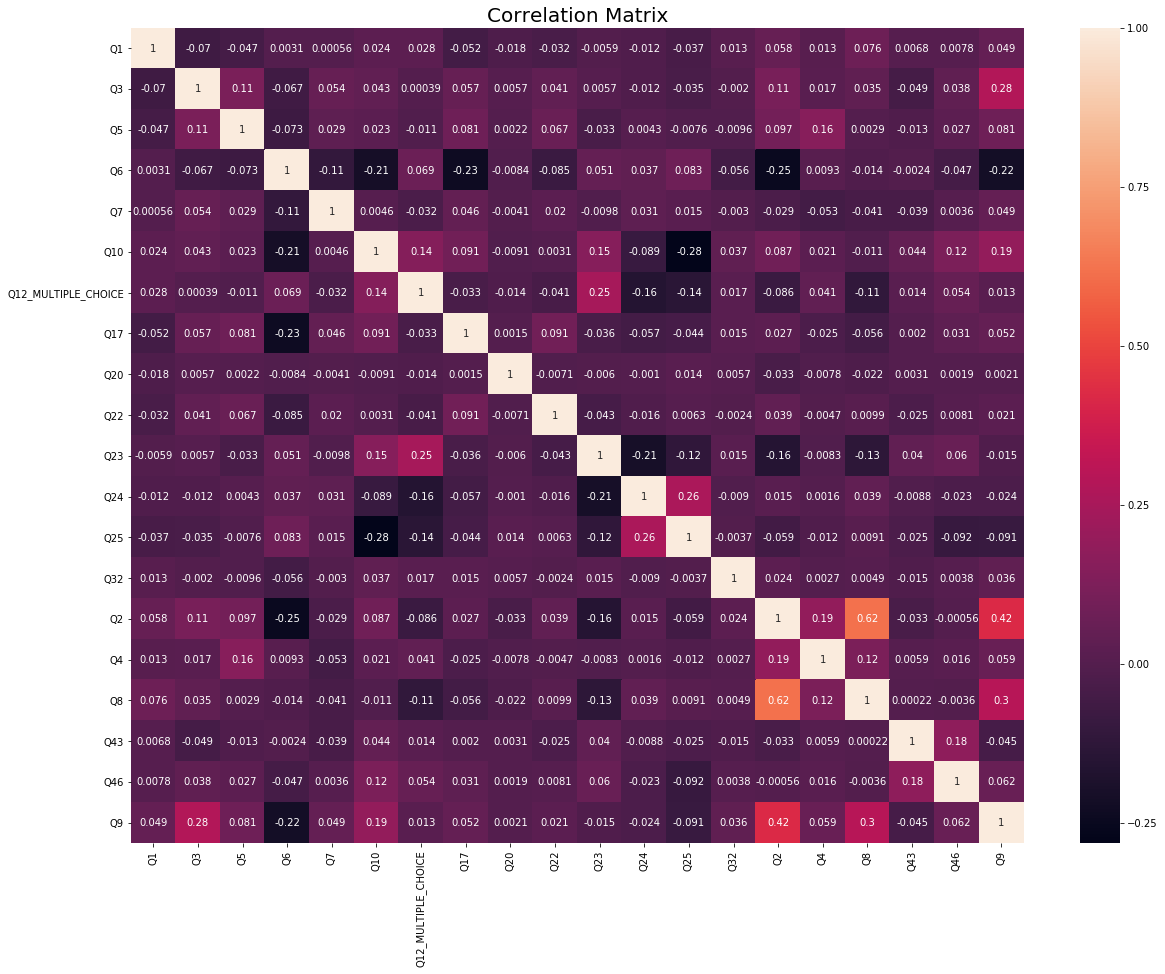

In [47]:
df_cor=single_ans_le.corr()
plt.figure(figsize=(20,15))
sns.heatmap(df_cor,xticklabels=df_cor.columns,yticklabels=df_cor.columns,annot=True)
plt.ylim(plt.ylim()[0]+0.5,plt.ylim()[1]-0.5) # update the ylim(bottom, top) values
plt.title('Correlation Matrix', fontsize=20)
plt.show()

It can be seen from the correlation heatmap that only correlation of target variable is good only with few features like age,country,experience and if the companies are incorporating ML techniques (Q2,Q3,Q10,Q8)

It can also be seen that Q25 (For how many years have you used machine learning methods (at work or in school)?) has negetive correlation with the target variable salary in USD

##### We can also use some regression models for feature selection instead of depending on correlation matrix. 
Here, Feature importance from Decision Tree Classifier, Random Forest Classifier and LASSO methods are illustrated.
1. Feature importance: In this method, each feature is evaluvated against target variable and importance is printed
2. In random forest classifier, feature reduction is done based on purity of the node and returns the feature id's to be considered
3. Lasso (least absolute shrinkage and selection operator) works on penality and does feature selection

To avoid redundant information and to avoid repetation of the same code functions are defined to carry out specific tasks. Now we load the actual feature data and target data and visualise the out put in the below order

    Function              Input                             Performs                           Output
    feature_sel----> Feature data and target data -----> Does feature selection     -----> Transformed feature data
    PCA        ----> Transformed feature data     -----> Dimension reduction        -----> Feature Data with reduced dimns
    CV_        ----> Reduced feature data and     -----> Cross validation           -----> Test and train accuracy for 
                     test data                           and accuracy scores               training data (splits) 
    plc        ----> Feature and target data,     -----> Evaluates train and test 
                     model name                          scores against observation -----> Plots the learning curves of 
                                                                                           train and test data


In [48]:
#Takes feature selection type, feature and target data as inputs, perform feature section fit and transform the feature data
#The transformed feature data is passed to PCA (primary component analysis) and calling cross validation with new feature data

def feature_sel(X,y,model):
    if model=='FI':
        #Fitting the data into classifier
        clf = SelectFromModel(DecisionTreeClassifier(random_state=10))
        clf.fit(X, y)
        #Assigning the feature data
        f1=X[X.columns[clf.get_support()]]
        print('Feature data shape after fitting the model is {}'.format(f1.shape))
        #PCA and Checking the accuracy of model
        f1,variance=PCA(f1)
        X_train, X_test, y_train, y_test=CV_(f1,y)
    elif model=='RF':
        #Fitting the data into classifier
        clf = SelectFromModel(RandomForestClassifier(n_estimators = 100,random_state=0))
        clf.fit(X, y)
        #Assigning the feature data
        f2=X[X.columns[clf.get_support()]]
        print('Feature data shape after fitting the model is {}'.format(f2.shape))
        #PCA and Checking the accuracy of model
        f2,variance=PCA(f2)
        X_train, X_test, y_train, y_test=CV_(f2,y)
    elif model=='LS':
        #Fitting the data into classifier
        #alpha is choosen to be 500 randomly after checking various accuracies, 
          #however tuning will be done and substituted by tuned parameter
        clf = SelectFromModel(Lasso(alpha=[500]).fit(X, y))
        clf.fit(X, y)
        #Assigning the feature data
        f3=X[X.columns[clf.get_support()]]
        print('Feature data shape after fitting the model is {}'.format(f3.shape))
        #PCA and Checking the accuracy of model
        f3,variance=PCA(f3)
        X_train, X_test, y_train, y_test=CV_(f3,y)
    return(variance,X_train, X_test, y_train, y_test)    

# 5. Model Implementation

Before implementation of our model, Since the distribution of salary is highly skewed towards lower salary groups we regroup the data into lesser classes(buckets)

In [49]:
target_data.groupby(target_data).count().head()

Q9
10000    4394
20000    1935
30000    1394
40000    1119
50000     964
Name: Q9, dtype: int64

In [50]:
#Since the distribution of salary is highly skewed towards lower salary groups we regroup the data into lesser classes(buckets)
target_data1=target_data.copy(deep=True)
target_data1[target_data1>150000]=200000
target_data1[target_data1==125000]=150000
target_data1[target_data1==80000]=100000
target_data1[target_data1==90000]=100000
target_data1[target_data1==60000]=70000
target_data1.groupby(target_data1).count()

Q9
10000     4394
20000     1935
30000     1394
40000     1119
50000      964
70000     1648
100000    1746
150000    1374
200000     828
Name: Q9, dtype: int64

Once feature selection is done using some classifier, further dimensional reduction is done using primary component analysis. Instead of choosing the number of components manually in PCA,we use the option that allows to set the variance of the input that is supposed to be explained by the generated components. In general 95-99% of varience is explained. If it is 100%, all the features to be taken in to consideration.

In [51]:
#Gets the new feature data after feature selection and impliments PCA, transformes feature data to reduced dimensions
#returns: explained variance ratio

def PCA(X):
        
    from sklearn.decomposition import PCA
    pca = PCA(n_components=0.99) #Explained varience of 99% so n_components is 0.99
    pca.fit(X)
    X=pca.transform(X)
    print('Feature data shape after PCA is {}'.format(X.shape))
    return(X,np.cumsum(pca.explained_variance_ratio_))

##### Evaluation: Cross Validation

When building a model, we want one that can generalize (low bias), and have similar accuracies across testing sets (low variance). However, we are lacking training and testing data. So, In cross-validation, we partition the training set into various training and testing sets and we use these sets to train and test the model multiple times.

Variations include Leave One Out Cross Validation, KFold Cross Validation, etc.

KFold Cross Validation is a common method where the training set is split into k equal sizes. Then of the k subsamples, a single sample is used for testing, and the remaining k-1 samples are used for training. This process continues k times, and each time a different sample is used for testing. This results in each sample being tested once. At the end of this we get 10 accuracies for the model and, from this, we can get the average accuracy, and the standard deviation of the accuracy. The higher the average accuracy, the lower the bias. The lower the standard deviation, the lower the variance. This better represents the true performance of the model on the training set.

In [52]:
#Gets the reduced feature data and performs splitting of data to train and test sets for cross validation, scales the data and 
#perform cross validation of data to predict the test and train accuracy 

#Note: test data, test accuracy in cross validation is not the unseen data (orinigal test set is tested later in testing discussion)

def CV_(X,y):
    
    scalar = StandardScaler()
    #splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4, test_size=0.3)
    
    #converting numpy arrays to DF
    X_train=pd.DataFrame(X_train)
    X_test=pd.DataFrame(X_test)
    y_train=pd.DataFrame(y_train)
    y_test=pd.DataFrame(y_test)
    
    model = LogisticRegression(C=0.1,solver='newton-cg',penalty='l2',multi_class='multinomial')
    
    kfold = KFold(n_splits=10)
    kfold.get_n_splits(X_train)
    
    #Initialising the values
    train_accuracy = np.zeros(10)
    test_accuracy = np.zeros(10)
    recall = np.zeros(10)
    precision = np.zeros(10)
    np_idx = 0

    for train_idx, test_idx in kfold.split(X_train):
        X_train_split, X_test_split = X_train.values[train_idx], X_train.values[test_idx]
        y_train_split, y_test_split = y_train.values[train_idx], y_train.values[test_idx]
    
        #Scaling the data sets since a lot of the models are based on the concept of Euclidean Distances 
        #so features with greater scales would have a greater impact on the solution, then those of smaller values.
        X_train_split = scalar.fit_transform(X_train_split)
        X_test_split= scalar.transform(X_test_split)
    
        model.fit(X_train_split, y_train_split)
        
        #predictions of the model against train/test data are stored
        test_predictions = model.predict(X_test_split)
        train_predictions = model.predict(X_train_split)
        
        #Calculating the required metrics to measure reliability of model
        CM=confusion_matrix(y_test_split, test_predictions)
        recall[np_idx] = np.mean(np.diag(CM) / np.sum(CM, axis = 1))
        precision[np_idx] = np.mean(np.diag(CM) / np.sum(CM, axis = 0))
        
        train_ACC=accuracy_score(y_train_split, train_predictions)
        test_ACC=accuracy_score(y_test_split, test_predictions)

        train_accuracy[np_idx] = train_ACC*100
        test_accuracy[np_idx] = test_ACC*100
        np_idx += 1
    
    print ("Average test Score: {}%({}%)".format(round(np.mean(test_accuracy),3),round(np.std(test_accuracy),3)))
    print ("Average train Score: {}%({}%)".format(round(np.mean(train_accuracy),3),round(np.std(train_accuracy),3)))
    print ("Average recall Score: {}%".format(round(np.mean(recall)*100,3)))
    print ("Average precision Score: {}%".format(round(np.mean(precision)*100,3)))
    
    plc(model, X_train, y_train, cv=10)
        
    
    return(X_train, X_test, y_train, y_test)

In [53]:
#For the validated models from Cross validation, we compute the train and test scores to plot the learning curve.
#Gets the estimator type and title, returns the plot of training score and test score against the no of observations

def plc(estimator, X, y, cv=10,ylim=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.title('Learning curve')

    plt.legend(loc="best")
    return plt

###### Giving the input to model

Now that we have defined functions for all the tasks. We feed the feature and test data into first function which is feature selection. The function calls are linked to each other to avoid feeding the data to individual functions. Debugging is tiresome in such cases. 

This fed feature and target data undergoes feature selection then PCA and cross validation to print the training and test accucracies along with precision and recall scores and also plots the learning curves for each case

Feature data shape after fitting the model is (15402, 191)
Feature data shape after PCA is (15402, 175)
Average test Score: 40.275%(1.521%)
Average train Score: 46.898%(0.333%)
Average recall Score: 29.376%
Average precision Score: 29.747%


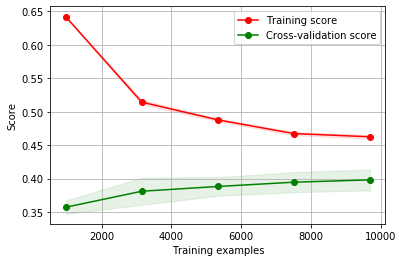

In [54]:
#Calling feature importance from decision tree and run the model to test the accuracy
fi_var,X_train_fi, X_test_fi, y_train_fi, y_test_fi=feature_sel(feature_data,target_data1,'FI')

Feature data shape after fitting the model is (15402, 194)
Feature data shape after PCA is (15402, 177)
Average test Score: 39.412%(1.65%)
Average train Score: 46.438%(0.133%)
Average recall Score: 28.287%
Average precision Score: 28.349%


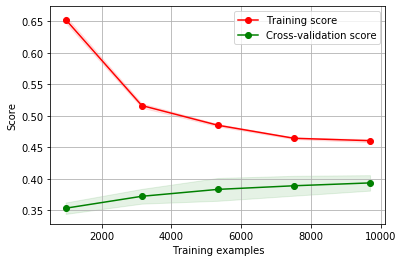

In [55]:
#Calling random forest classifier and run the model to test the accuracy
rf_var,X_train_rf, X_test_rf, y_train_rf, y_test_rf=feature_sel(feature_data,target_data1,'RF')

Feature data shape after fitting the model is (15402, 59)
Feature data shape after PCA is (15402, 54)
Average test Score: 40.516%(2.123%)
Average train Score: 42.873%(0.118%)
Average recall Score: 28.808%
Average precision Score: 30.582%


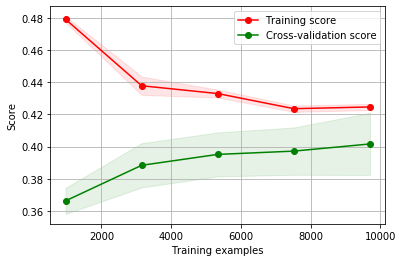

In [56]:
#Calling lasso logistic regression and run the model to test the accuracy
ls_var,X_train_ls, X_test_ls, y_train_ls, y_test_ls=feature_sel(feature_data,target_data1,'LS')

It is observed that different choosing various feature selection model yields different accuracy of the model. 

Through the accuracy is better in Lasso(model 3), we cannot conclude that model is best as the accuracy can be improved by tuning the parameters of other models too. But Lasso uses little number of columns and gives almost same accuracy as the others thereby decreasing the complexity and computation time.
Hence we use Lasso for further tuning of parameters and modelling.

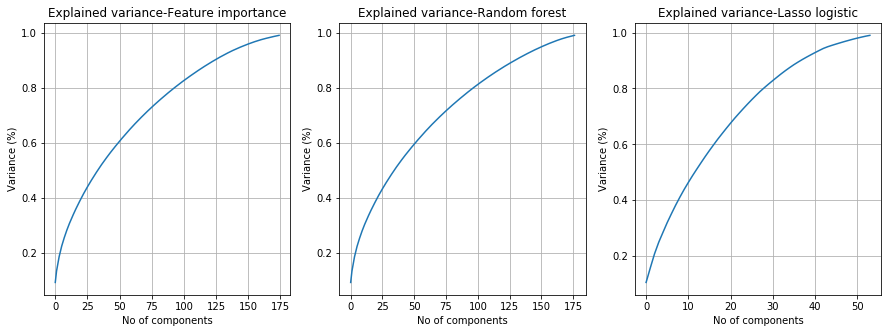

In [57]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))
ax1.plot(fi_var)
ax1.set_title('Explained variance-Decision Tree')
ax2.plot(rf_var)
ax2.set_title('Explained variance-Random forest')
ax3.plot(ls_var)
ax3.set_title('Explained variance-Lasso logistic')

for ax in [ax1,ax2,ax3]:
    ax.set(xlabel='No of components', ylabel='Variance (%)')
    ax.grid()

From the above variance curves, we can see that in Lasso method around 50 features are able to explain 99% variance of the data set whereas in other methods, to explain 99% variance we need to consider atleast 175 features.

# 6. Model Tuning

Grid search, random grid search and pipeline are some of the model tuning options available to iterate the model with n number of folds to check the best parameters which gives high accuracy of the model.

Grid search uses systematic way of estimating the parameters and compares the accuracy of each parameter combination where as random grid search chooses randomly and compare the accuracy. Random grid is faster. While pipeline method can take more than 1 model to compare the parameters and gives the best possible combination.

In [ ]:
# param_grid={'C' :(0.001,0.01,0.05,0.1,0.5,1,5,10,100,1000),
#                 'solver' : ['newton-cg','sag', 'saga','lbfgs']}

# lr = LogisticRegression(penalty='l2')

# random = RandomizedSearchCV(estimator=lr, param_distributions=param_grid, cv = 3, n_jobs=-1, verbose=True)

# random_result = random.fit(feature_data,target_data1)


Printing the best parameters and best accuracy.

In [59]:
# print('Best score is {}:'.format(random_result.best_score_))
# print('Best parameters are {}:'.format(random_result.best_params_))

Best score is 0.4094273470977795:
Best parameters are {'solver': 'lbfgs', 'C': 0.1}:


Using pipeline for finding the best parameter for lasso classifier

In [62]:
# pipe = Pipeline([('classifier' , LogisticRegression())])

# param_grid = [
#     {'classifier' : [Lasso()],
#     'classifier__alpha' : list(range(100,1000,100))},
#     {'classifier' : [LogisticRegression(penalty='l2',multi_class='multinomial')],
#      'classifier__C' :(0.01,0.05,0.1,0.5,0.75,1),
#     'classifier__solver' : ['newton-cg','sag', 'saga','lbfgs']}
# ]


# gcv = GridSearchCV(pipe, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)# Create grid search object

# best_fit = gcv.fit(feature_data, target_data1)# Fit on data


Fitting 3 folds for each of 33 candidates, totalling 99 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed: 10.6min finished


In [63]:
# print('Best score is {}:'.format(gcv.best_score_))
# print('Best parameters are {}:'.format(gcv.best_params_))

Best score is 0.5941136592194897:
Best parameters are {'classifier': Lasso(alpha=100, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False), 'classifier__alpha': 100}:


Now that the hyper parameters are tuned, We proceed to build the selected model using the above parameters and fit the feature and target data. But before that, we can also check the error of the model which explains the bias-variance trade off.

This is also a type of hyper parameter tuning considering the log loss error of training and test sets.
We wont use the parameters given by randomisegrid search. We can use any method illustrated but to explain bias-variance tradeoff we choose below method 

In [65]:
best_clf = SelectFromModel(Lasso(alpha=[100]).fit(feature_data, target_data1))
best_clf.fit(feature_data,target_data1)

best_X=feature_data[feature_data.columns[best_clf.get_support()]]
       
best_X,variance=PCA(best_X)

#Random state is to be used as the same one used for cross validation tp maintain consistancy
X_train, X_test, y_train, y_test = train_test_split(best_X, target_data1, random_state=4, test_size=0.3)

Feature data shape after PCA is (15402, 158)


For modelling the best fit, first we select the features using lasso method using tuned parameter alpha, then using the regression parameters from log loss error we define the best fit then input the feature and target data to predict the accuracies and probability of out put belonging to particular class

In [68]:
#Defining the models required
model = LogisticRegression(multi_class='multinomial')
scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X_train)

#Initializing the arrays/objects to use in loop
best_model = model
best_params = {}
best_accuracy = 0
best_std = 0
trainE_=np.zeros(40)
testE_=np.zeros(40)
acc=np.zeros(40)
err_idx=0

#converting numpy arrays to DF
X_train=pd.DataFrame(X_train)
X_test=pd.DataFrame(X_test)
y_train=pd.DataFrame(y_train)
y_test=pd.DataFrame(y_test)

for C in [0.001,0.01,0.05,0.1,0.5,1,5,10,100,1000]:
    for solver in ['newton-cg','lbfgs','sag','saga']:
        
        #Fitting the model with various values of C & solver which are hyperparameters
        model = LogisticRegression(multi_class='multinomial',C=C, solver=solver,max_iter=300)
        accuracy = np.zeros(10)
        train_err = np.zeros(10)
        test_err = np.zeros(10)
        
        np_idx = 0
        
        #Using 10 folds cross validation to get best parameters
        for train_idx, test_idx in kfold.split(X_train):
            X_train_split, X_test_split = X_train.values[train_idx], X_train.values[test_idx]
            y_train_split, y_test_split = y_train.values[train_idx], y_train.values[test_idx]

            model.fit(X_train_split, y_train_split)
            
            test_predic = model.predict_proba(X_test_split)
            train_predic =model.predict_proba(X_train_split) 
            test_predic_acc = model.predict(X_test_split)
            train_predic_acc =model.predict(X_train_split)

            CM=confusion_matrix(y_test_split, test_predic_acc)
            ACC=accuracy_score(y_test_split, test_predic_acc)
            accuracy[np_idx] = ACC*100
            
            #Errors in the each step are loaded in to an array which can be plotted as error curve
            train_err[np_idx] = np.mean(log_loss(y_train_split, train_predic))
            test_err[np_idx] = np.mean(log_loss(y_test_split, test_predic))
        
            np_idx += 1
        
        trainE_[err_idx] = np.mean(train_err)
        testE_[err_idx] = np.mean(test_err)    
        acc[err_idx] = np.mean(accuracy)
                
        err_idx+=1
        
        #Checking the accuracy to decide on best parameters
        if np.mean(accuracy) > best_accuracy:
            best_model = model
            best_params = {'C':C, 'solver':solver}
            best_accuracy = np.mean(accuracy)
            best_std = np.std(accuracy)

print (best_params)
print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      

print ("\nThe optimal log model uses C={}, and a {} solver, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],best_params['solver'],round(best_accuracy,3),round(best_std,3)))

{'C': 100, 'solver': 'newton-cg'}
Best Score: 42.065%(1.644%)

The optimal log model uses C=100, and a newton-cg solver, and has a cross validation score of 42.065% with a standard deviation of 1.644%


In [69]:
testE1=pd.DataFrame(testE_.reshape(10,4))
trainE1=pd.DataFrame(trainE_.reshape(10,4))

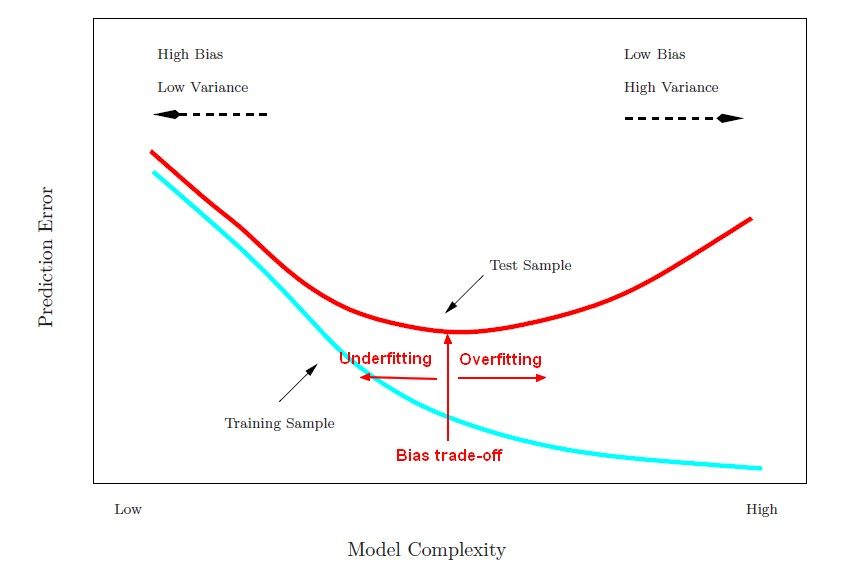 The above image is taken for reference from web, which explains bias-variance trade off. In our analysis we plot a similar curve and check the bias and variance using the error values against sample size

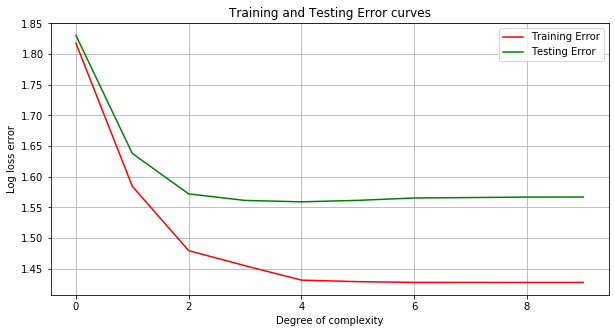

In [116]:
plt.figure(figsize=(10,5))
plt.plot(trainE1.iloc[:,0:1],'r',label='Training Error')
plt.plot(testE1.iloc[:,0:1],'g',label='Testing Error')
# plt.plot(trainE1.iloc[:,0:1] + testE1.iloc[0:-1,0:1], 'b', label='Total Error')

test_min = testE1.iloc[:,0:1].min()
tot_min=(trainE1.iloc[:,0:1] + testE1.iloc[:,0:1]).min()

deg_min = np.array(testE1.iloc[:,0:1]).argmin()
# total_deg_min = np.array((trainE1.iloc[:,0:1] + testE1.iloc[:,0:1])).argmin()

plt.title("Training and Testing Error curves")
plt.xlabel("Degree of complexity")
plt.ylabel("Log loss error")
plt.legend(loc=1)
plt.grid()


We need to have low bias and low variance for a good model
From graph, the minimum error on test data is 1.55 with a degree of complexity of aprox. 4 units.  

# 7. Best fit of the Model

In [71]:
#Fitting the model with the tuned parameters
# best_model = LogisticRegression(C=random_result.best_params_['C'],solver=random_result.best_params_['solver'])
best_model = LogisticRegression(C=100,solver='newton-cg')

scaler = StandardScaler()

#Scaling the data to avoid innaccuray
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

best_model.fit(X_train_ls, y_train_ls)
predictions_ls = best_model.predict(X_test_ls)
acc_ls=accuracy_score(y_test_ls,predictions_ls)*100
print('Accuracay of the train model after parameter tuning is is {}%'.format(round(acc_ls,3)))

best_model = LogisticRegression(C=best_params['C'],solver=best_params['solver'])
best_model.fit(X_train, y_train)
predictions = best_model.predict(X_test)
acc=accuracy_score(y_test,predictions)*100

print('Accuracay of the model on unseen data is {}%'.format(round(acc,3)))

Accuracay of the train model after parameter tuning is is 42.177%
Accuracay of the model on unseen data is 42.783%


It is found that the accuracy of the model on unseen data is 42.783%
Less accuracy is due to skewed data. We can improve the accuracy by considering minimal number of features so that over fitting of data can be avoided. 

##### Improved accuracy after hyper parameter tuning
We note that before hyper parameter tuning, the accuracy of the training data was 40.275% and now with tuned parameters we see an improvement in accuracy and the new accuracy is 42.177%


In [72]:
results=pd.DataFrame(y_test)
results['Predicted']=predictions
results.columns=['Actual','Predicted']
print(results)

       Actual  Predicted
13516   40000     100000
8734   200000     100000
2875   150000     100000
5290   100000     100000
2502   150000     150000
...       ...        ...
13081   40000      10000
4292    30000      20000
5155    30000      20000
14899   10000      10000
7686   100000      20000

[4621 rows x 2 columns]


In [154]:
probability=pd.DataFrame(model.predict_proba(X_test),columns=model.classes_.astype(str))
probability.columns=(probability.columns).map({'20000': '10-20000', '10000': '0-10000', '30000':'20-30000', '150000':'100-150000','40000':'30-40000','70000':'50-70000','50000':'40-50000','100000':'70-100000','200000':'200000+'})

In [159]:
probability.loc[2060]

0-10000       1.538433e-10
10-20000      2.452439e-07
20-30000      3.504955e-07
30-40000      3.110786e-04
40-50000      9.712529e-01
50-70000      2.648379e-02
70-100000     1.733427e-03
100-150000    6.388975e-05
200000+       1.542924e-04
Name: 2060, dtype: float64

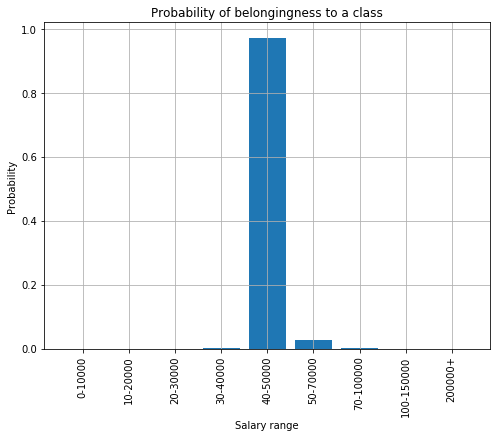

In [158]:
plt.figure(figsize=(8,6))
plt.bar(probability.columns,probability.loc[2060])
plt.xticks(rotation=90)
plt.xlabel('Salary range')
plt.ylabel('Probability')
plt.title('Probability of belongingness to a class')
plt.grid()
plt.show()

The probability graph shows the probability of some respondent that could belong to a particular salary bucket. As per the developed model, this respondents salary will most likely falls in 30-40000 USD range. Like-wise we can predict the salary of respondent based on their survey response.

But the accuracy of the model is around 42% which indicate that the prediction that the respondents salary is exactly 40-50000 in the plotted example is 0.42x0.97x100=40.74% (accuracy of model x probability of belongingness to the class as predicted by model)

# 8. Discussion

1. Hence, we performed required data cleaning on the dataset given, replaced, imputed the missing and obnormal values, encoded them using label encoding and 1 hot encoding.
2. Using the cleaned data, feature selection techniques are used to select important features and performed PCA for dimension reduction and stored as a Dataframe.
3. Model accuracy before tuning is tested against various feature selection techniques which are reported to be
   
        Decision Tree-
        Average test Score: 40.275%(1.521%)
        Average train Score: 46.898%(0.333%)
    
        Random forest classifier-
        Average test Score: 39.412%(1.65%)
        Average train Score: 46.438%(0.133%)
    
        LASSO-
        Average test Score: 40.516%(2.123%)
        Average train Score: 42.873%(0.118%)
        
4. Model test accuracy post parameter tuning is 42.177% against 40.516% of LASSO model. Hence we can say that parameter tuning can increase the accuracy to some extent
5. Also from error curve the best parameters choosen are the minimum error point on test set which gives balance on bias and variance. Any other parameters will either lead to over or under fit as per the figure attached in model tuning section.

